In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


In [2]:
class Network(nn.Module): 
    def __init__(self):                                                                
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self,t):
        t = F.relu(self.conv1(t))                          #简洁书写，将卷积与relu结合在一起
        t = F.max_pool2d(t,kernel_size=2,stride=2)     
        
        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
        t = F.relu(self.fc1(t.reshape(-1,12*4*4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t 

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root = 'data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([              #torchvision.transforms是pytorch中的图像预处理包。一般用Compose把多个步骤整合到一起
        transforms.ToTensor()
    ])
)

In [4]:
network = Network()                                                    

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)   
optimizer = optim.Adam(network.parameters(), lr=0.01)                  


In [5]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat((all_preds,preds),dim=0)
    return all_preds

In [6]:
prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [7]:
train_preds.shape

torch.Size([60000, 10])

In [8]:
print(train_preds.requires_grad)    #这意味着这个特定的张量需要pytorch的梯度跟踪性
#requires_grad: 如果需要为张量计算梯度，则为True，否则为False。我们使用pytorch创建tensor时，可以指定requires_grad为True（默认为False），

True


In [9]:
train_preds.grad

<ipython-input-9-54316e76a7d0>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  train_preds.grad


In [10]:
train_preds.grad_fn    #grad_fn： grad_fn用来记录变量是怎么来的，方便计算梯度，y = x*3,grad_fn记录了y由x计算的过程。
###这个值是导致这个张量创造出来的函数

In [11]:
with torch.no_grad():             # 被torch.no_grad()包裹起来的部分不会被追踪梯度，虽然仍可以前向传播进行计算得到输出，但计算过程(grad_fn)不会被记录，也就不能反向传播更新参数。
    prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)
    
#这是一个简单的例子说明pytorch在局部进行梯度跟踪

In [12]:
print(train_preds.requires_grad) 

False


In [13]:
train_preds.grad         

In [14]:
train_preds.grad_fn       #因为没有做任何的反向传播

In [15]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [16]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print('total correct:',preds_correct)
print('accuracy:',preds_correct / len(train_set))

total correct: 5987
accuracy: 0.09978333333333333


# 创建一个混淆矩阵

In [17]:
#在机器学习领域，混淆矩阵（Confusion Matrix），又称为可能性矩阵或错误矩阵。混淆矩阵是可视化工具，特别用于监督学习，在无监督学习一般叫做匹配矩阵。
#在图像精度评价中，主要用于比较分类结果和实际测得值，可以把分类结果的精度显示在一个混淆矩阵里面。

In [18]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [19]:
train_preds.argmax(dim=1)

tensor([2, 2, 2,  ..., 2, 2, 2])

In [20]:
stacked = torch.stack(
    (
        train_set.targets,
        train_preds.argmax(dim=1)
    ),dim=1
)

In [21]:
stacked.shape

torch.Size([60000, 2])

In [22]:
stacked

tensor([[9, 2],
        [0, 2],
        [0, 2],
        ...,
        [3, 2],
        [0, 2],
        [5, 2]])

In [23]:
stacked[0].tolist() #将其变成一个python列表

[9, 2]

In [24]:
cmt= torch.zeros(10,10,dtype=torch.int32)  #想要一个10*10的混淆矩阵先创建一个全0矩阵
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [25]:
j, k = stacked[0].tolist()

In [26]:
j

9

In [27]:
k

2

In [28]:
for p in stacked:       #在这个for循环中，对于stack张量中的每一对，我们想要把这对变成j和k
    tl, pl = p.tolist()
    cmt[tl,pl] = cmt[tl,pl] + 1

In [29]:
cmt         #在上一节的优化器情况下才会效果好

tensor([[   0,    0, 5998,    0,    0,    0,    0,    0,    0,    2],
        [   0,    0, 5820,    0,    0,    0,    0,    0,    0,  180],
        [   0,    0, 5987,    0,    0,    0,    0,    0,    0,   13],
        [   0,    0, 5996,    0,    0,    0,    0,    0,    0,    4],
        [   0,    0, 5999,    0,    0,    0,    0,    0,    0,    1],
        [   0,    0, 5949,    0,    0,    0,    0,    0,    0,   51],
        [   0,    0, 5996,    0,    0,    0,    0,    0,    0,    4],
        [   0,    0, 5961,    0,    0,    0,    0,    0,    0,   39],
        [   0,    0, 5984,    0,    0,    0,    0,    0,    0,   16],
        [   0,    0, 6000,    0,    0,    0,    0,    0,    0,    0]],
       dtype=torch.int32)

# 绘画一个混淆矩阵

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [34]:
from resources.plotcm import plot_confusion_matrix  

In [35]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[   0,    0, 5998,    0,    0,    0,    0,    0,    0,    2],
       [   0,    0, 5820,    0,    0,    0,    0,    0,    0,  180],
       [   0,    0, 5987,    0,    0,    0,    0,    0,    0,   13],
       [   0,    0, 5996,    0,    0,    0,    0,    0,    0,    4],
       [   0,    0, 5999,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0, 5949,    0,    0,    0,    0,    0,    0,   51],
       [   0,    0, 5996,    0,    0,    0,    0,    0,    0,    4],
       [   0,    0, 5961,    0,    0,    0,    0,    0,    0,   39],
       [   0,    0, 5984,    0,    0,    0,    0,    0,    0,   16],
       [   0,    0, 6000,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

Confusion matrix, without normalization
[[   0    0 5998    0    0    0    0    0    0    2]
 [   0    0 5820    0    0    0    0    0    0  180]
 [   0    0 5987    0    0    0    0    0    0   13]
 [   0    0 5996    0    0    0    0    0    0    4]
 [   0    0 5999    0    0    0    0    0    0    1]
 [   0    0 5949    0    0    0    0    0    0   51]
 [   0    0 5996    0    0    0    0    0    0    4]
 [   0    0 5961    0    0    0    0    0    0   39]
 [   0    0 5984    0    0    0    0    0    0   16]
 [   0    0 6000    0    0    0    0    0    0    0]]


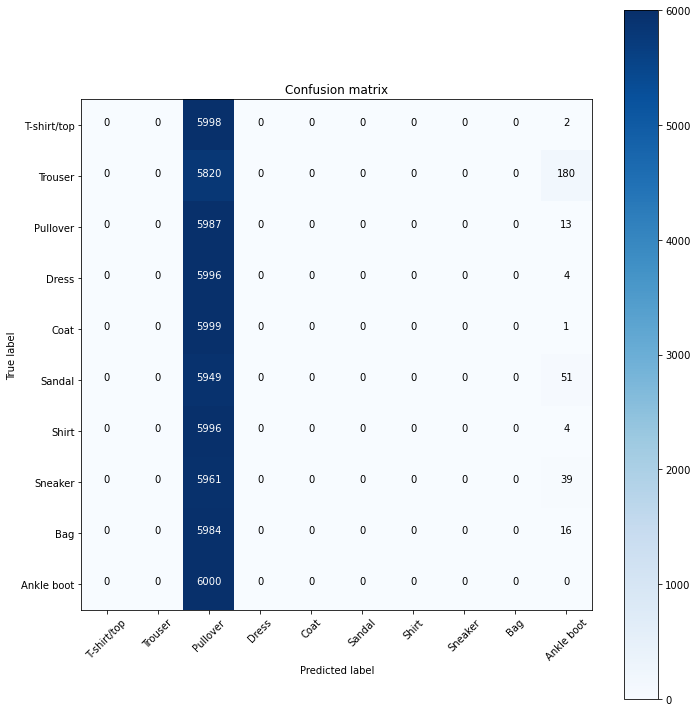

In [36]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)
